In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.integrate import quad

from time import perf_counter as time
from tqdm import tqdm
from scipy import linalg
from scipy import stats

## 1a

In [150]:
def u(x): return 1/(2 - np.cos(x))

M = 200
x_array = np.linspace(0, 2*np.pi, M)

N = 100
n_array = np.arange(-N, N+1)
denominator = np.sqrt(3) * ((2 + np.sqrt(3))**(np.abs(n_array)))
cn = 1/denominator

A_fourier = np.exp(1j * x_array[:, None] * n_array[None, :])
B = (A_fourier * cn[None, :])
f_x = np.sum(B, axis = 1)
print(B.shape, cn.shape, f_x.shape)

resid = u(x_array) - f_x

(200, 201) (201,) (200,)


In [151]:
resid_array = np.zeros((N-1, M))
for i in range(N - 1):
    i_left, i_right = N - i - 1, N + i + 1
    resid_array[i, :] = u(x_array) - np.sum(B[:, i_left:(i_right+1)], axis=1)

# print(resid_norm.shape)
resid_norm = np.linalg.norm(resid_array, axis = 1)

/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1984129839.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  resid_array[i, :] = u(x_array) - np.sum(B[:, i_left:(i_right+1)], axis=1)


/opt/anaconda3/envs/scicom/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/scicom/lib/python3.12/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


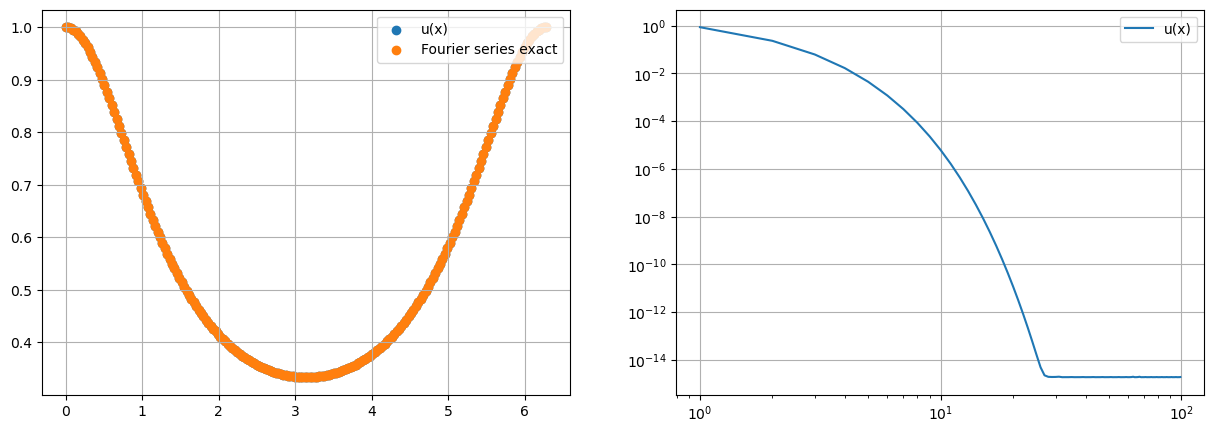

In [152]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].scatter(x_array, u(x_array), label = "u(x)")
ax[0].scatter(x_array, f_x, label = "Fourier series exact")
ax[0].legend(loc = "upper right")
ax[0].grid()
ax[1].loglog(np.arange(1, N), resid_norm, label = "u(x)")
ax[1].legend(loc = "upper right")
ax[1].grid()

## 1b

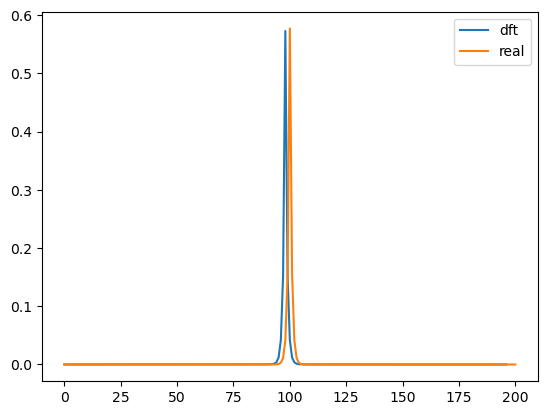

In [153]:
dft_array = np.zeros((N-1, M), dtype = complex)
for N_dft in range(N - 1):
    dft_components = np.fft.fftshift(np.fft.fft(a = u(x_array), n = 2*N_dft + 1, norm = "forward"))
    # print(dft_components.shape)


plt.plot(dft_components.real, label = "dft")
plt.plot(cn, label = "real")
plt.legend()

## 1c

In [7]:
N = 7
h = 2*np.pi / N
x_array = np.arange(N) * h
print(x_array)

[0.         0.8975979  1.7951958  2.6927937  3.5903916  4.48798951
 5.38558741]


In [8]:
def lagrange_polynomial(xj, x, N):
    return (1/N)*(np.sin((N/2)*(x - xj)) * np.cos((x - xj)/2) / np.sin((x - xj)/2))

In [9]:
x_plot = np.linspace(0, 2*np.pi, 1000)

# for xj in x_array:
#     plt.plot(x_plot, lagrange_polynomial(xj = xj, x = x_plot, N = N), label = f"xj = {xj:.2f}")
#     plt.axvline(x = xj, color = "k", linestyle = "--", alpha = 0.3)
# plt.grid()
# plt.legend()
# plt.show();

In [10]:
N_grid = np.logspace(1, 2.9, num=50, dtype = int)
N_grid += N_grid % 2

results = np.zeros(shape = (N_grid.shape[0]))
for i, N in enumerate(N_grid):

    # N = 6
    h = 2*np.pi / N
    x_array = np.arange(N) * h

    def f_test(x):
        return x*(2*np.pi - x)

    def I_N(x, x_array):
        u_array = f_test(x_array)
        result = np.zeros(shape = (x_array.shape[0], x.shape[0]))
        for j, xj in enumerate(x_array):
            result[j, :] = u_array[j] * lagrange_polynomial(xj = xj, x = x, N = len(x_array))
        return result

    u_array = f_test(x_array)
    X = I_N(x = x_plot, x_array = x_array)
    # print(f"{X.shape = }")
    f_lagrange = np.sum(X, axis = 0)

    diff = f_lagrange - f_test(x_plot)
    diff = diff[~np.isnan(diff)]

    results[i] = linalg.norm(diff, ord = np.inf)

/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/3452291567.py:2: RuntimeWarning: invalid value encountered in divide
  return (1/N)*(np.sin((N/2)*(x - xj)) * np.cos((x - xj)/2) / np.sin((x - xj)/2))


In [11]:
res = stats.linregress(np.log(N_grid), np.log(results))
print(f"{res.slope = }")
print(f"{res.intercept = }")

res.slope = np.float64(-1.0529548345789306)
res.intercept = np.float64(2.203930274071407)


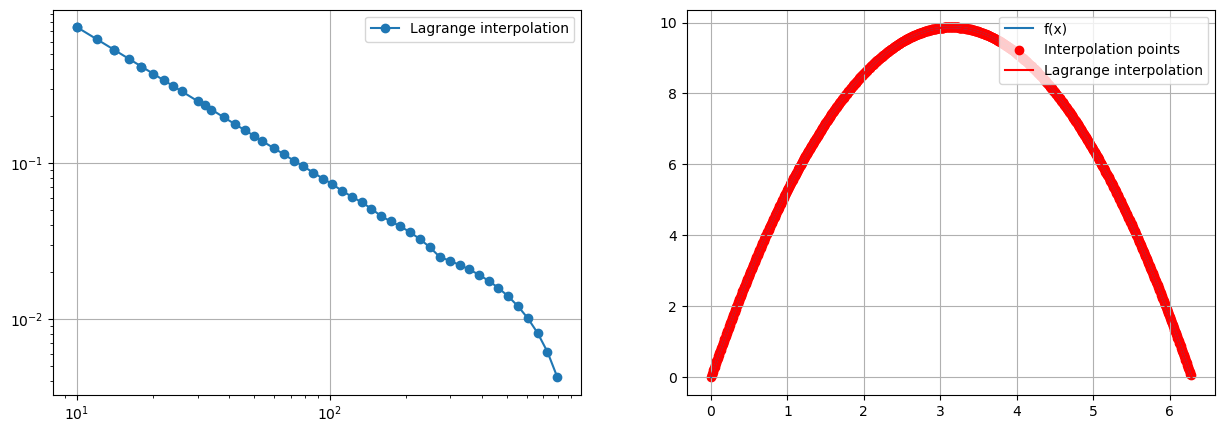

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].loglog(N_grid, results, label = "Lagrange interpolation", marker = "o")   
ax[0].grid()
ax[0].legend(loc = "upper right")

ax[1].plot(x_plot, f_test(x_plot))
ax[1].scatter(x_array, u_array, color = "red")
ax[1].plot(x_plot, f_lagrange, color = "red")
ax[1].grid()
ax[1].legend(["f(x)", "Interpolation points", "Lagrange interpolation"], loc = "upper right")
plt.show();

## 1d

In [88]:
# def h_jk(k, j): return 1/2 * (-1)**(np.abs(k + j)) * np.cos(1/N * np.pi * (np.abs(j - k))) / np.sin(1/N * np.pi * (np.abs(j - k)))
def h_jk(k, j, N_input):
    diff = k - j
    # return 1/2 * np.power(-1.0, diff) * np.cos(1/N_input * np.pi * diff) / np.sin(1/N_input * np.pi * diff)
    return 1/2 * np.power(-1.0, diff) * np.cos(1/N_input * np.pi * diff) / np.sin(1/N_input * np.pi * diff)

def get_D(N_input, index_array = None):
    if index_array is None:
        index_array = np.arange(N_input)
    D_deriv = h_jk(k = index_array[:, None], j = index_array[None, :], N_input = N_input)
    np.fill_diagonal(D_deriv, 0.0)
    return D_deriv

In [89]:
N = 10
def v(x): return np.exp(np.sin(x))
def dv(x): return np.exp(np.sin(x)) * np.cos(x)

# def v(x): return np.cos(x)
# def dv(x): return -np.sin(x)

# def v(x): return np.cos(x)*np.where(x < 0, -1, 1) 
# def dv(x): return np.sin(x)*np.where(x < 0, 1, -1)

h = 2*np.pi / N
x_array = np.arange(N) * h

v_array = v(x_array)
dv_array = dv(x_array)

print(v_array)
print(dv_array)

D = get_D(N_input = N)

dv_D = D @ v_array

print(np.linalg.norm(dv_array - dv_D, ord = np.inf))

[1.         1.79999746 2.58844295 2.58844295 1.79999746 1.
 0.55555634 0.38633264 0.38633264 0.55555634]
[ 1.          1.45622853  0.79987286 -0.79987286 -1.45622853 -1.
 -0.44945452 -0.11938335  0.11938335  0.44945452]
0.003169472178362942


/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1979874789.py:5: RuntimeWarning: divide by zero encountered in divide
  return 1/2 * np.power(-1.0, diff) * np.cos(1/N_input * np.pi * diff) / np.sin(1/N_input * np.pi * diff)


0.003169472178362942


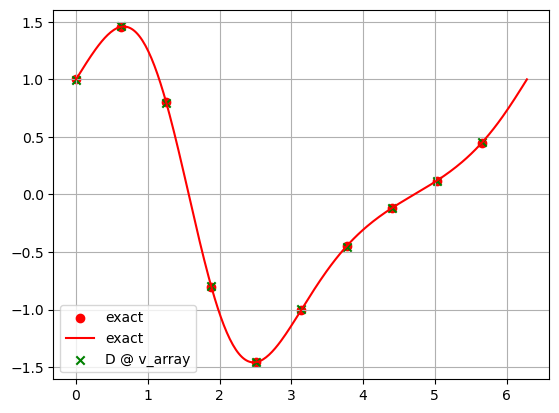

In [90]:
x_plot = np.linspace(0, 2*np.pi, 300)

print(np.linalg.norm(dv_array - dv_D, ord = np.inf))

plt.scatter(x_array, dv_array, label = "exact", color = "red")
plt.plot(x_plot, dv(x_plot), label = "exact", color = "red")
plt.scatter(x_array, dv_D, label = "D @ v_array", marker = "x", color = "green")
plt.legend()
plt.grid();

In [105]:
N_max = 50
N_grid = np.arange(2, N_max, step = 4)
# N_grid = np.logspace(1, 2.2, num = 50, dtype = int)
N_grid += N_grid % 2

result = np.zeros(shape = N_grid.shape[0])
for i, N_test in enumerate(N_grid):

    indexes_array = np.arange(N_test)
    x_array = indexes_array * 2*np.pi / N_test
    v_array = v(x_array)
    dv_array = dv(x_array)
    
    D = h_jk(k = indexes_array[:, None], j = indexes_array[None, :], N_input = N_test)
    np.fill_diagonal(D, 0.0)

    dv_D = D @ v_array

    # result[i] = np.linalg.norm(dv_array - dv_D, ord = np.inf)
    result[i] = np.linalg.norm(dv_array - dv_D, ord = np.inf)

    # plt.scatter(x_array, dv_array, label = "exact", color = "red")
    # plt.scatter(x_array, dv_D, label = "D @ v_array", marker = "x", color = "green")
    # # plt.title(f"N = {N_text}, error = {result[i]:.2e}")

/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1979874789.py:5: RuntimeWarning: divide by zero encountered in divide
  return 1/2 * np.power(-1.0, diff) * np.cos(1/N_input * np.pi * diff) / np.sin(1/N_input * np.pi * diff)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1727888833.py:17: RuntimeWarning: divide by zero encountered in matmul
  dv_D = D @ v_array
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1727888833.py:17: RuntimeWarning: overflow encountered in matmul
  dv_D = D @ v_array
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1727888833.py:17: RuntimeWarning: invalid value encountered in matmul
  dv_D = D @ v_array


In [114]:
res = stats.linregress(N_grid[N_grid <= 30], np.log(result)[N_grid <= 30])

-1.2234019346712603

<>:5: SyntaxWarning: invalid escape sequence '\i'
<>:5: SyntaxWarning: invalid escape sequence '\i'
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/4232149436.py:5: SyntaxWarning: invalid escape sequence '\i'
  ax.set_ylabel("$|| v' - Dv||_{\infty}$ on $x_k = 2k\pi/N$")


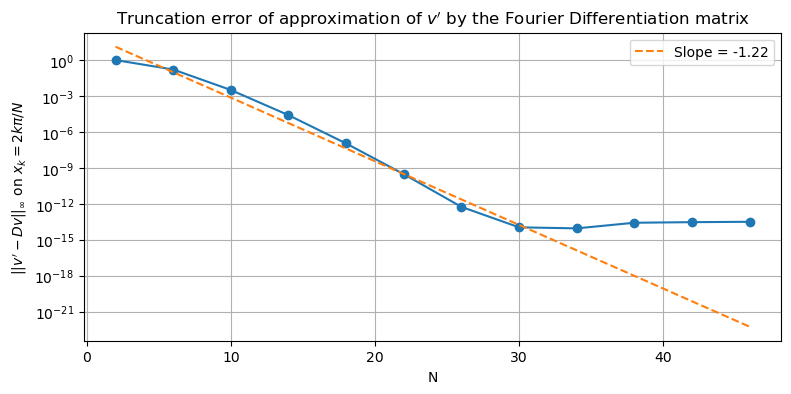

In [124]:
fig, ax = plt.subplots(1, 1, figsize = (9, 4))
# ax.loglog(N_grid, result, marker = "o");
ax.semilogy(N_grid, result, marker = "o");
ax.semilogy(N_grid, np.exp(res.intercept + N_grid*res.slope) , linestyle = "--", label = f"Slope = {float(res.slope) :.2f}")
ax.set_ylabel("$|| v' - Dv||_{\infty}$ on $x_k = 2k\pi/N$")
ax.set_xlabel("N")
ax.set_title("Truncation error of approximation of $v'$ by the Fourier Differentiation matrix")
ax.legend(loc = "upper right")
ax.grid();
plt.savefig("report/output/1d_convergence_test.png", dpi=600)

## 1e

In [48]:
# Defining functions
# def w0(x): return np.cos(x)*np.where(x < 0, -1, 1) 
# def w1(x): return np.sin(x)*np.where(x < 0, -1, 1)
# def w2(x): return (np.cos(x) + 1)*np.where(x <= 0, 1, -1)
# def w3(x): return (np.sin(x) + x - 2)*np.where(x <= 0, 1, -1)

def w0(x):
    x = np.asarray(x)
    mask = (x >= -2*np.pi) & (x <= 0)
    return np.cos(x) * np.where(mask, -1.0, 1.0)

def w1(x):
    x = np.asarray(x)
    mask = (x >= -2*np.pi) & (x <= 0)
    return np.sin(x) * np.where(mask, -1.0, 1.0)

def w2(x):
    x = np.asarray(x)
    mask = (x >= -2*np.pi) & (x <= 0)
    base = np.cos(x) - 1.0
    return base * np.where(mask, 1.0, -1.0)

def w3(x):
    x = np.asarray(x)
    mask = (x >= -2*np.pi) & (x <= 0)
    base = np.sin(x) - x
    return base * np.where(mask, 1.0, -1.0)

In [54]:
N = 50
# x_array = np.arange(N) * 2*np.pi / N
x_array = np.arange(-N, N) * 2*np.pi / N

# w0_array = w0(x_array)
w1_array = w1(x_array)
# w2_array = w2(x_array)
# w3_array = w3(x_array)

D = get_D(N_input = 2*N, index_array=np.arange(-N, N))
# D = get_D(N_input = N)

w0_D = D @ w1_array
# w1_D = D @ w2_array
# w2_D = D @ w3_array

x_plot = np.linspace(-2*np.pi, 2*np.pi, 300)

/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/3656342784.py:4: RuntimeWarning: divide by zero encountered in divide
  return 1/2 * np.power(-1.0, diff) * np.cos(1/N_input * np.pi * diff) / np.sin(1/N_input * np.pi * diff)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/853984044.py:13: RuntimeWarning: divide by zero encountered in matmul
  w0_D = D @ w1_array
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/853984044.py:13: RuntimeWarning: overflow encountered in matmul
  w0_D = D @ w1_array
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/853984044.py:13: RuntimeWarning: invalid value encountered in matmul
  w0_D = D @ w1_array


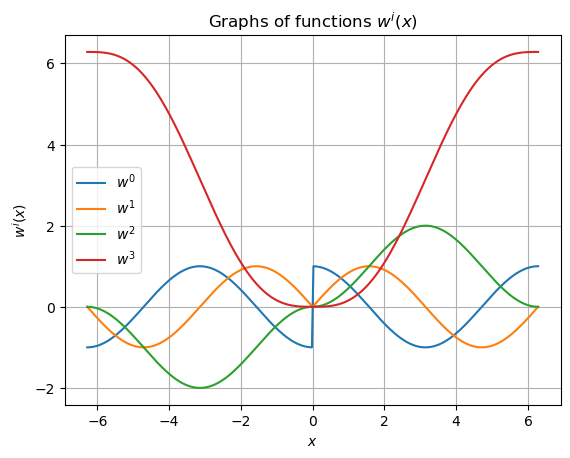

In [57]:
plt.plot(x_plot, w0(x_plot), label = "$w^0$")
plt.plot(x_plot, w1(x_plot), label = "$w^1$")
plt.plot(x_plot, w2(x_plot), label = "$w^2$")
plt.plot(x_plot, w3(x_plot), label = "$w^3$")
plt.legend()
plt.title("Graphs of functions $w^i(x)$")
plt.xlabel("$x$")
plt.ylabel("$w^i(x)$")
plt.grid();
plt.savefig("report/output/1e_functions.png", dpi=600)

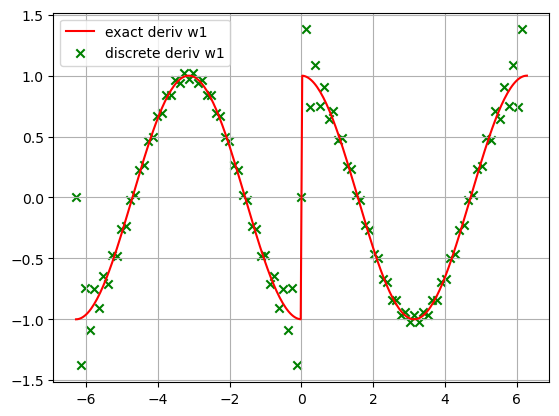

In [58]:
x_plot = np.linspace(-2*np.pi, 2*np.pi, 300)
# plt.scatter(x_array, w1_array, label = "exact", color = "red")
plt.plot(x_plot, w0(x_plot), label = "exact deriv w1", color = "red")
plt.scatter(x_array, w0_D / 2, label = "discrete deriv w1", marker = "x", color = "green")
plt.legend()
plt.grid();

In [59]:
def h_deriv_j(xj, x, N_input):
    dx = x - xj
    term1 = (N_input / 2) * np.cos((N_input / 2) * dx) * (1 / np.tan(0.5 * dx))
    term2 = (1 / N_input) * np.sin((N_input / 2) * dx) / (np.sin(0.5 * dx) ** 2)
    return (1 / N_input) * (term1 - term2)

N = 10
M = 20

x_lagrange_N_array = np.arange(-N, N) * 2*np.pi / N
x_evaluate = np.arange(-M, M) * 2*np.pi / M
print(f"{x_lagrange_N_array.shape = }, {x_evaluate.shape = }")

def h_deriv_across_N(x, xj_array):
    N_input = xj_array.shape[0]
    result = np.zeros(shape = (N_input, x.shape[0]))
    for j, xj in enumerate(xj_array):
        result[j, :] = h_deriv_j(xj = xj, x = x, N_input = N_input)
    # result_sum = np.sum(result, axis = 0) # PLAIN WRONG
    w_on_xj_array = w1(xj_array)
    result_sum = w_on_xj_array @ result
    return result_sum

h_deriv_sum = h_deriv_across_N(x = x_evaluate, xj_array = x_lagrange_N_array)

x_lagrange_N_array.shape = (20,), x_evaluate.shape = (40,)


/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1437193085.py:3: RuntimeWarning: divide by zero encountered in divide
  term1 = (N_input / 2) * np.cos((N_input / 2) * dx) * (1 / np.tan(0.5 * dx))
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1437193085.py:4: RuntimeWarning: invalid value encountered in divide
  term2 = (1 / N_input) * np.sin((N_input / 2) * dx) / (np.sin(0.5 * dx) ** 2)


In [138]:
# general formulas for Lagrange polynomials and their derivatives

def lagrange_poly(x, xj, N, T = 2*np.pi):
    diff = 0.5 * (x - xj) * (2 * np.pi / T)
    return (1 / N) * np.sin(N * diff) / np.tan(diff)

def lagrange_poly_deriv(x, xj, N, T = 2*np.pi):
    diff = (x - xj) * (2 * np.pi / T)
    term1 = 0.5 * np.cos((N / 2.0) * diff) / np.tan(0.5 * diff)
    term2 = (1 / (2 * N)) * np.sin((N / 2) * diff) / (np.sin(0.5 * diff) ** 2)
    out = (2 * np.pi / T) * (term1 - term2)
    out = np.where(np.isclose(diff, 0.0), 0.0, out)
    return out

def trig_interp_derivative(x_nodes, f_nodes, x_eval, T):
    N = len(x_nodes)
    LJp = lagrange_poly_deriv(x = x_eval[:, None], xj = x_nodes[None, :], N = N, T = T)
    return LJp @ f_nodes 

def trig_interp_derivative_FOR_QUADRATURE(x, x_nodes, f_nodes, T):
    N = len(x_nodes)
    LJp = lagrange_poly_deriv(x = x, xj = x_nodes[None, :], N = N, T = T)
    return LJp @ f_nodes  # shape (M,)


f = w1
fp = w0

f = w2
fp = w1

# f = w3
# fp = w2

N = 30
x_min, x_max = -2*np.pi, 2*np.pi
T = x_max - x_min
x_nodes = np.linspace(x_min, x_max, N, endpoint=False)
f_nodes = f(x_nodes)

def f_integrate(x, deriv_true, x_nodes, f_nodes, T):
    return (deriv_true(x) - trig_interp_derivative_FOR_QUADRATURE(x, x_nodes, f_nodes, T))**2

l2_integral = quad(f_integrate, x_min, x_max, args=(fp, x_nodes, f_nodes, T, ))
print(f"{l2_integral = }")

M = 200
x_eval = np.linspace(x_min, x_max, M, endpoint=False)
fp_approx = trig_interp_derivative(x_nodes, f_nodes, x_eval, T)

l2_integral = (0.002933704561068281, 6.999119544138823e-09)


/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1870549402.py:9: RuntimeWarning: divide by zero encountered in divide
  term1 = 0.5 * np.cos((N / 2.0) * diff) / np.tan(0.5 * diff)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1870549402.py:10: RuntimeWarning: invalid value encountered in divide
  term2 = (1 / (2 * N)) * np.sin((N / 2) * diff) / (np.sin(0.5 * diff) ** 2)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1870549402.py:18: RuntimeWarning: divide by zero encountered in matmul
  return LJp @ f_nodes
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1870549402.py:18: RuntimeWarning: overflow encountered in matmul
  return LJp @ f_nodes
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1870549402.py:18: RuntimeWarning: invalid value encountered in matmul
  return LJp @ f_nodes


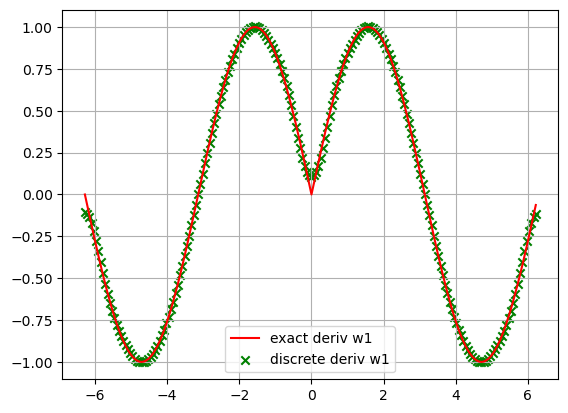

In [139]:
plt.plot(x_eval, fp(x_eval), label = "exact deriv w1", color = "red")
plt.scatter(x_eval, fp_approx, label = "discrete deriv w1", marker = "x", color = "green")
plt.legend()
plt.grid();

In [140]:
f = w3
fp = w2

list_functions = [(w1, w0), (w2, w1), (w3, w2)]

x_min, x_max = -2*np.pi, 2*np.pi
T = x_max - x_min

def f_integrate(x, deriv_true, x_nodes, f_nodes, T):
    return (deriv_true(x) - trig_interp_derivative_FOR_QUADRATURE(x, x_nodes, f_nodes, T))**2

N_grid = np.logspace(1, 2.5, num=50, dtype = int)
N_grid += N_grid % 2

results = np.zeros(shape = (len(list_functions), N_grid.shape[0]))

for func_index, (f, fp) in enumerate(tqdm(list_functions)):
    for i, N in enumerate(N_grid):
        x_nodes = np.linspace(x_min, x_max, N, endpoint=False)
        f_nodes = f(x_nodes)

        l2_integral = quad(f_integrate, x_min, x_max, args=(fp, x_nodes, f_nodes, T, ))
        
        results[func_index, i] = l2_integral[0]

  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1870549402.py:9: RuntimeWarning: divide by zero encountered in divide
  term1 = 0.5 * np.cos((N / 2.0) * diff) / np.tan(0.5 * diff)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1870549402.py:10: RuntimeWarning: invalid value encountered in divide
  term2 = (1 / (2 * N)) * np.sin((N / 2) * diff) / (np.sin(0.5 * diff) ** 2)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/609469942.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  l2_integral = quad(

100%|██████████| 3/3 [00:00<00:00, 3989.51it/s]


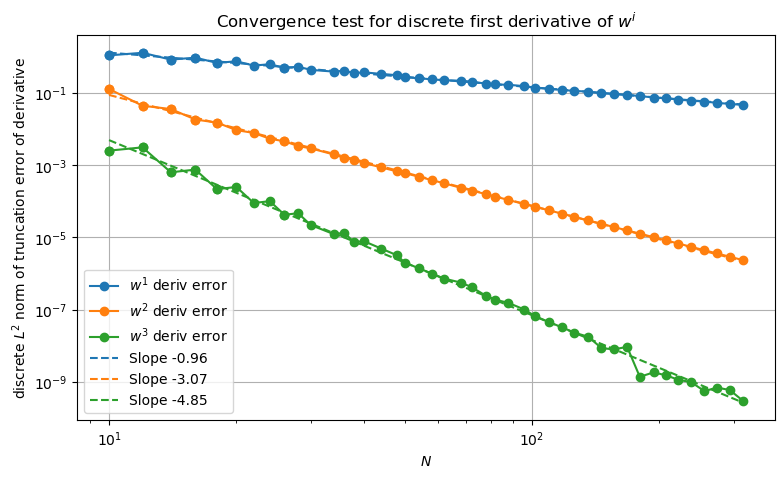

In [141]:
regression_results = np.zeros(shape = (len(list_functions), 2))
for func_index, (f, fp) in enumerate(tqdm(list_functions)):
    res = stats.linregress(np.log(N_grid), np.log(results[func_index, :]))
    regression_results[func_index, 0] = res.intercept
    regression_results[func_index, 1] = res.slope

colors = ["C0", "C1", "C2"]

fig, ax = plt.subplots(1,1, figsize = (9, 5))

ax.loglog(N_grid, results[0, :], marker = "o", label = "$w^1$ deriv error", color = colors[0])
ax.loglog(N_grid, results[1, :], marker = "o", label = "$w^2$ deriv error", color = colors[1])
ax.loglog(N_grid, results[2, :], marker = "o", label = "$w^3$ deriv error", color = colors[2])

ax.loglog(N_grid, np.exp(regression_results[0, 0])*N_grid**regression_results[0, 1], color = colors[0], linestyle = "--", label = f"Slope {regression_results[0, 1]:.2f}")
ax.loglog(N_grid, np.exp(regression_results[1, 0])*N_grid**regression_results[1, 1], color = colors[1], linestyle = "--", label = f"Slope {regression_results[1, 1]:.2f}")
ax.loglog(N_grid, np.exp(regression_results[2, 0])*N_grid**regression_results[2, 1], color = colors[2], linestyle = "--", label = f"Slope {regression_results[2, 1]:.2f}")

ax.set_ylabel("discrete $L^2$ norm of truncation error of derivative")
ax.set_xlabel("$N$")
ax.set_title("Convergence test for discrete first derivative of $w^i$")
ax.legend()
ax.grid();
plt.savefig("report/output/1e_convergence_test_wi.png", dpi=600)

## 1f

In [143]:
N = 16
def v(x): return np.exp(np.sin(x))
def dv(x): return np.exp(np.sin(x)) * np.cos(x)

h = 2*np.pi / N
x_array = np.arange(N) * h

v_array = v(x_array)
dv_array = dv(x_array)

D = get_D(N_input = N)
dv_D = D @ v_array

print(np.linalg.norm(dv_array - dv_D, ord = np.inf))

1.76189313139119e-07


/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1979874789.py:5: RuntimeWarning: divide by zero encountered in divide
  return 1/2 * np.power(-1.0, diff) * np.cos(1/N_input * np.pi * diff) / np.sin(1/N_input * np.pi * diff)


In [144]:
dft_components = np.fft.fft(v_array, n=N, norm="forward")
diffx_FFT = np.fft.ifft(1j * np.fft.fftshift(np.arange(-N/2, N/2)) * dft_components, norm = "forward")

1.76189313139119e-07


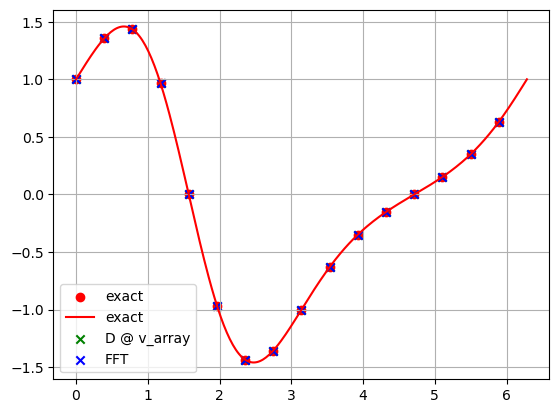

In [145]:
x_plot = np.linspace(0, 2*np.pi, 300)

print(np.linalg.norm(dv_array - dv_D, ord = np.inf))

plt.scatter(x_array, dv_array, label = "exact", color = "red")
plt.plot(x_plot, dv(x_plot), label = "exact", color = "red")
plt.scatter(x_array, dv_D, label = "D @ v_array", marker = "x", color = "green")
plt.scatter(x_array, diffx_FFT.real, label = "FFT", marker = "x", color = "blue")
plt.legend()
plt.grid();

In [146]:
N_max = 100
N_grid = np.logspace(1, 4, num=N_max).astype(int)
N_grid += N_grid % 2

K_simulations = 10

result = np.zeros(shape = (K_simulations, 2, N_grid.shape[0]))
result_l2 = np.zeros(shape = (K_simulations, 2, N_grid.shape[0]))
times = np.zeros(shape = (K_simulations, 2, N_grid.shape[0]))

for k in tqdm(range(K_simulations)):
    for i, N_test in enumerate(N_grid):

        indexes_array = np.arange(N_test)
        x_array = indexes_array * 2*np.pi / N_test
        v_array = v(x_array)
        dv_array = dv(x_array)

        D = get_D(N_input = N_test)
        start = time()
        dv_D = D @ v_array
        times[k, 0, i] = time() - start

        dft_components = np.fft.fft(v_array, n=N_test, norm="forward")
        start = time()
        diffx_FFT = np.fft.ifft(1j * np.fft.fftshift(np.arange(-N_test/2, N_test/2)) * dft_components, norm = "forward")
        times[k, 1, i] = time() - start

        result[k, 0, i] = np.linalg.norm(dv_array - dv_D, ord = np.inf) 
        result[k, 1, i] = np.linalg.norm(dv_array - diffx_FFT, ord = np.inf)

        result_l2[k, 0, i] = np.linalg.norm(dv_array - dv_D, ord = 2) 
        result_l2[k, 1, i] = np.linalg.norm(dv_array - diffx_FFT, ord = 2)

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1979874789.py:5: RuntimeWarning: divide by zero encountered in divide
  return 1/2 * np.power(-1.0, diff) * np.cos(1/N_input * np.pi * diff) / np.sin(1/N_input * np.pi * diff)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1413856295.py:21: RuntimeWarning: divide by zero encountered in matmul
  dv_D = D @ v_array
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1413856295.py:21: RuntimeWarning: overflow encountered in matmul
  dv_D = D @ v_array
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/1413856295.py:21: RuntimeWarning: invalid value encountered in matmul
  dv_D = D @ v_array
100%|██████████| 10/10 [02:28<00:00, 14.87s/it]


In [147]:
result_l2_scaled = result_l2 / N_grid

result_mean = np.mean(result_l2_scaled, axis = 0)
times_mean = np.mean(times, axis = 0)
print(times_mean.shape)

(2, 100)


In [148]:
def ls(x, y, mask = None):
    x = x[mask]
    y = y[mask]
    A = np.c_[(np.ones(x.shape[0]), x)]
    beta = linalg.solve(A.T @ A, A.T @ y)
    return beta

# X = np.c_[(np.ones(N_grid.shape[0]), np.log(N_grid))]
# considered_obs = N_grid > 50
# X = X[considered_obs, :]
# beta_D = linalg.solve(X.T @ X, X.T @ np.log(times[0, considered_obs]))
# print(beta)

beta_D = ls(np.log(N_grid), np.log(times_mean[0, :]), mask = N_grid > 100)
beta_fft = ls(np.log(N_grid), np.log(times_mean[1, :]), mask = N_grid > 100)

coef_fft = times_mean[1, N_grid > 100] / N_grid[N_grid > 100] * np.log(N_grid[N_grid > 100])
coef_fft = np.mean(np.log(coef_fft))

<>:16: SyntaxWarning: invalid escape sequence '\;'
<>:31: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\;'
<>:31: SyntaxWarning: invalid escape sequence '\d'
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/3994166350.py:16: SyntaxWarning: invalid escape sequence '\;'
  label = "$O(N\;log(N))$")
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_241/3994166350.py:31: SyntaxWarning: invalid escape sequence '\d'
  ax[1].set_ylabel("$ \dfrac{1}{N} ||v' - \hat{v'}||_2 $")


beta_D = array([-21.36139725,   1.7392995 ]), beta_fft = array([-15.09469749,   0.80749768]), coef_fft = np.float64(-14.512459255246762)


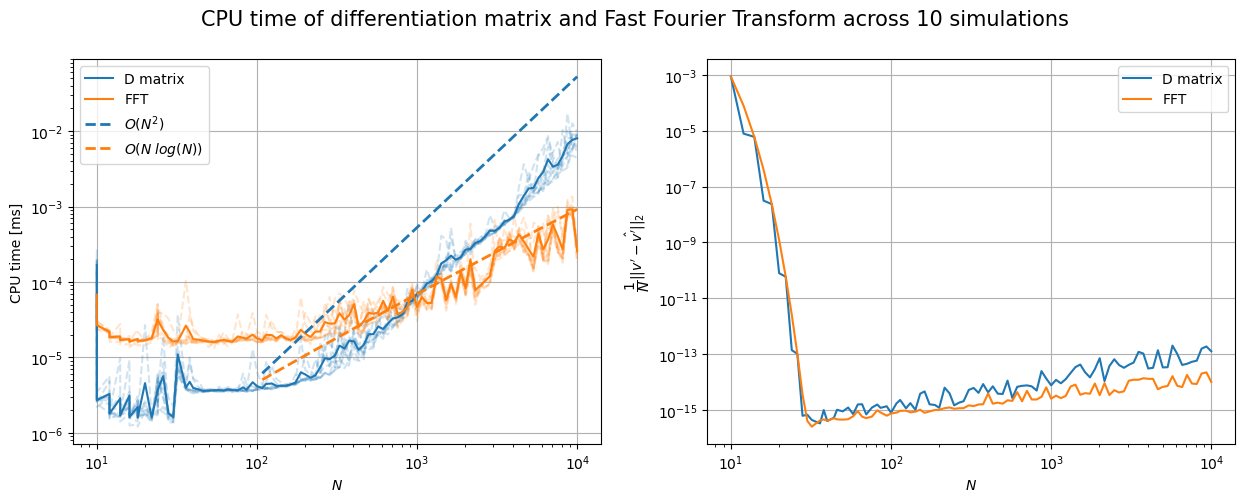

In [149]:
print(f"{beta_D = }, {beta_fft = }, {coef_fft = }")

alpha = 0.2

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

for k in range(K_simulations):
    ax[0].loglog(N_grid, times[k, 0, :], linestyle='--', alpha = alpha, color = "C0");
    ax[0].loglog(N_grid, times[k, 1, :], linestyle='--', alpha = alpha, color = "C1");
ax[0].loglog(N_grid, times_mean[0, :], label = "D matrix", color = "C0");
ax[0].loglog(N_grid, times_mean[1, :], label = "FFT", color = "C1");
ax[0].loglog(N_grid[N_grid > 100], (np.exp(beta_D[0])*N_grid**2)[N_grid > 100], linestyle='--', color = "C0", linewidth=2,
             label = "$O(N^2)$")
# ax[0].loglog(N_grid[N_grid > 100], (np.exp(beta_fft[0] - 2)*N_grid**(1))[N_grid > 100], linestyle='--', color = "C1")
ax[0].loglog(N_grid[N_grid > 100], ((1e-8)*N_grid*np.log(N_grid))[N_grid > 100], linestyle='--', color = "C1", linewidth=2,
             label = "$O(N\;log(N))$")
# plt.loglog(N_grid, np.exp(coef_fft)*N_grid*np.log(N_grid), linestyle='--', color = "orange")
ax[0].set_xlabel("$N$")
ax[0].set_ylabel("CPU time [ms]")
ax[0].grid();
ax[0].legend();

# for k in range(K_simulations):
#     ax[1].loglog(N_grid, result_l2_scaled[k, 0, :], linestyle='--', alpha = alpha, color = "C2");
#     ax[1].loglog(N_grid, result_l2_scaled[k, 1, :], linestyle='--', alpha = alpha, color = "C3");
ax[1].loglog(N_grid, result_mean[0, :], label = "D matrix", color = "C0");
ax[1].loglog(N_grid, result_mean[1, :], label = "FFT", color = "C1");
ax[1].grid();
ax[1].legend();
ax[1].set_xlabel("$N$")
ax[1].set_ylabel("$ \dfrac{1}{N} ||v' - \hat{v'}||_2 $")

#     ax2.set_title(f"Error ($N={N}$)")
#     ax2.set_xlabel("$n$")
#     ax2.set_ylabel("$|\\tilde{c}_n| - |c_n|$")

plt.suptitle("CPU time of differentiation matrix and Fast Fourier Transform across 10 simulations", fontsize=15)
# plt.tight_layout()
# plt.savefig("report/output/1f_FFT_D_CPU_time.png", dpi=600)
plt.show();